# Cooperative Kernel regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## **Partie 1 :** 

Solvers pour les différentes méthodes (on a choisi de faire de la POO)

In [47]:
def kernel(x,y):
    return np.exp(-(x-y)**2)

def compute_doubly_stochastic_matrix(adjacence_matrix):
    n,p = np.shape(adjacence_matrix)
    doubly_stochastic_matrix = np.copy(adjacence_matrix)
    max_sum = np.max(np.array([np.sum(adjacence_matrix[i]) for i in range(n)]))
    for i in range(n):
        doubly_stochastic_matrix[i,i] = max_sum -(np.sum(adjacence_matrix[i])-1)
    return(doubly_stochastic_matrix/max_sum)


class instance:
    def __init__(self,X,centers_kernel,Y,kernel_center_of_agent,data_point_of_agent,communication_matrix,sigma) -> None:
        self.centers_kernel=centers_kernel
        self.X = X
        self.Y=Y
        self.kernel_center_of_agent = kernel_center_of_agent
        self.data_point_of_agent = data_point_of_agent
        self.communication_matrix = communication_matrix
        self.sigma = sigma
        number_of_kernels = np.shape(centers_kernel)[0]
        number_of_datas = np.shape(X)[0]
        self.number_of_datas = number_of_datas
        self.number_of_kernels = number_of_kernels
        self.Kmm_matrix = np.array([[kernel(centers_kernel[k],centers_kernel[l]) for k in range(number_of_kernels)]for l in range(number_of_kernels)])
        self.Knm_matrix = np.array([[kernel(centers_kernel[k],X[l]) for k in range(number_of_kernels)]for l in range(self.number_of_datas)])
        number_of_agents,kernels_per_agent = np.shape(kernel_center_of_agent)
        _,data_per_agent = np.shape(data_point_of_agent)
        self.number_of_agents = number_of_agents
        self.kernels_per_agent = kernels_per_agent
        self.data_per_agent = data_per_agent
        matrixA = np.identity(number_of_agents*number_of_kernels)
        for index in range(number_of_kernels):
                matrixA[(number_of_agents-1)*number_of_kernels+index,(number_of_agents-1)*number_of_kernels+index]=0
        for index in range((number_of_agents-1)*number_of_kernels):
                matrixA[index,index+number_of_kernels]=-1
        self.matrixA = matrixA
        self.true_solution = np.zeros(number_of_agents)

    def objective(self,curent_solution):
        objecti = np.dot(curent_solution,np.dot(self.Kmm_matrix,curent_solution))/2
        for agent_index in range(self.number_of_agents):
            for agent_index_2 in range(self.data_per_agent):
                matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
                objecti+=(1/(2*(self.sigma**2)))*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,curent_solution))**2
        return(objecti)
    
    def gradient(self,agent_index,point):
        sum  = np.dot(self.Kmm_matrix,point)/5    
        for agent_index_2 in range(self.data_per_agent):
            matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
            sum -=matrix_Kim*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,point))/(self.sigma**2)
        return sum
    
    def complete_gradient(self,point):
        product = np.dot(self.Knm_matrix.T,self.Knm_matrix) 
        grad = np.dot(self.Kmm_matrix+(1/self.sigma**2)*product,point)
        grad -= (1/self.sigma**2)*np.dot(self.Y.T,self.Knm_matrix)
        return(grad)
    
    def partial_gradient(self,agent_index,point,agent_index_2):
        sum  = np.dot(self.Kmm_matrix,point)/5    
        matrix_Kim = np.array([kernel(self.X[self.data_point_of_agent[agent_index,agent_index_2]],self.centers_kernel[j]) for j in range(self.number_of_kernels)])
        sum -=matrix_Kim*(self.Y[self.data_point_of_agent[agent_index,agent_index_2]]-np.dot(matrix_Kim,point))/(self.sigma**2)
        return sum
    



class solver : 

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        self.instance = instance1
        self.step_size = step_size
        self.number_iteration = number_iteration
        self.initialisation = initialisation
        self.variable_zize = np.shape(initialisation)[0]

class gradient_descent(solver):
    def __init__(self, instance1, step_size, number_iteration, initialisation) -> None:
        super().__init__(instance1, step_size, number_iteration, initialisation)
        self.curent_solution = initialisation
        self.new_solution = initialisation

    def solve(self,verbose = True):
        for iteration in range(self.number_iteration):
            self.do_gradient_descent_step()
            self.curent_solution = self.new_solution
            if verbose:
                self.display_objective()
        return(self.curent_solution)

    def do_gradient_descent_step(self):    
        gradient = self.instance.complete_gradient(self.curent_solution)
        self.new_solution = self.curent_solution - self.step_size*gradient
    
    def display_objective(self):
        print("Objective : "+str(self.instance.objective(self.curent_server_solution)))


class DGD(solver):
    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))
        self.original_communication_matrix = compute_doubly_stochastic_matrix(self.instance.communication_matrix)
        self.effective_communication_matrix = compute_doubly_stochastic_matrix(self.instance.communication_matrix)


    def solve(self,verbose = True, package_loss = False,probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose:
                print("Iterration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)

            self.do_optimisation_step_DGD(verbose,package_loss,probability_package_loss)

            if package_loss:
                self.reinitialize_communication_matrix()

            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)
    
    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)
    
    def do_optimisation_step_DGD(self,verbose = True,package_loss = False,probability_package_loss = 0):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        
        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)
    
        if verbose : 
            self.display_objective()
        self.curent_solution = self.new_solution

    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = compute_doubly_stochastic_matrix(sampled_adjacence_matrix)

    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))


class gradient_tracking(DGD):

    def __init__(self,instance1,step_size,number_iteration,initialisation) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
        self.new_gradient_like = np.array([self.instance.gradient(agent_index,initialisation) for agent_index in range(instance1.number_of_agents)])
    
    def reinitialize_communication_matrix(self):
        return super().reinitialize_communication_matrix()
    
    def sample_effective_communication_matrix(self, probability_package_loss):
        return super().sample_effective_communication_matrix(probability_package_loss)

    def solve(self,verbose = True,package_loss = False,probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose :
                print("Iterration : "+str(iteration))
            self.do_optimisation_step_gradient_tracking(verbose,package_loss,probability_package_loss)
            self.update_distance_to_optimum(iteration)
        return(self.curent_solution)

    def do_optimisation_step_gradient_tracking(self,verbose=True,package_loss = False,probability_package_loss = 0):
        self.new_solution = np.zeros([self.instance.number_of_agents,self.variable_zize])
        self.new_gradient_like = np.zeros([self.instance.number_of_agents,self.variable_zize])
        if package_loss:
            self.sample_effective_communication_matrix(probability_package_loss)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_descent(agent_index,verbose)

        for agent_index in range(self.instance.number_of_agents):
            self.do_local_gradient_like_update(agent_index)
        if package_loss:
            self.reinitialize_communication_matrix()

        self.curent_solution = self.new_solution
        self.curent_gradient_like = self.new_gradient_like
        if verbose :
            self.display_objective()

    def do_local_gradient_descent(self,agent_index,verbose=True):
        gradient = self.curent_gradient_like[agent_index]
        if verbose : 
            print("Agent " + str(agent_index)+" norme du gradient (gradient like) : "+str(np.linalg.norm(gradient)))
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_solution[agent_index]+=self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_solution[agent_index_2]
        self.new_solution[agent_index]-=self.step_size*gradient

    def do_local_gradient_like_update(self,agent_index):
        for agent_index_2 in range(self.instance.number_of_agents):
            self.new_gradient_like[agent_index]+= self.effective_communication_matrix[agent_index,agent_index_2]*self.curent_gradient_like[agent_index_2]
        gradient_iteration_k = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        gradient_iteration_k_plus_1 = self.instance.gradient(agent_index,self.new_solution[agent_index])
        self.new_gradient_like[agent_index]-= gradient_iteration_k
        self.new_gradient_like[agent_index]+= gradient_iteration_k_plus_1
        
    def display_objective(self):
        return super().display_objective()
    
    def update_distance_to_optimum(self, iteration):
        return super().update_distance_to_optimum(iteration)


class dual_decomposition(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = initialisation_dual
        self.new_dual_variable = initialisation_dual
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix


    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step(verbose)
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
         gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
         agent_index_th_column_of_A = self.instance.matrixA[:,agent_index*self.instance.number_of_kernels:(agent_index+1)*self.instance.number_of_kernels].T
         communication_vector = np.array([self.effective_communication_matrix[agent_index] for index in range(self.instance.number_of_kernels)]).T.flatten()
         components_of_dual_variable_communicated = self.curent_dual_variable*communication_vector
         gradient += np.dot(agent_index_th_column_of_A,components_of_dual_variable_communicated)
         self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
         self.new_primal_solution[agent_index]-=self.step_size*gradient
         

    def do_dual_ascent_step(self,verbose=True):
        self.new_dual_variable = self.curent_dual_variable
        gradient = np.dot(self.instance.matrixA,self.curent_primal_solution.flatten())
        if verbose : 
            print("Norme du gradient : "+str(np.linalg.norm(gradient)))
        self.new_dual_variable += self.step_size_dual*gradient

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose : 
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
         for primal_iteration in range(self.number_iteration):
              self.do_primal_iteration_step(agent_index)

    def do_primal_iteration_step(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_primal_solution[agent_index]) 
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        self.new_primal_solution[agent_index]=self.curent_primal_solution[agent_index]
        self.new_primal_solution[agent_index]-=self.step_size*gradient
    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index_1,agent_index_2]==1:
                    self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)

class dual_decomposition_edge_linalg(solver):

    def __init__(self,instance1,step_size_primal,step_size_dual,number_iteration_primal,number_iteration_dual,initialisation, initialisation_dual,regularization) -> None:
        super().__init__(instance1,step_size_primal,number_iteration_primal,initialisation)
        self.curent_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.new_primal_solution = np.array([initialisation for i in range(instance1.number_of_agents)])
        self.step_size_dual = step_size_dual
        self.number_iteration_dual = number_iteration_dual
        self.curent_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.new_dual_variable = np.array([[initialisation_dual for index in range(self.instance.number_of_agents)]for index2 in range(self.instance.number_of_agents)])
        self.distance_to_optimum = np.zeros((self.number_iteration_dual,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
        self.regularization = regularization
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration_dual):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.do_dual_ascent_step()
            self.curent_dual_variable = self.new_dual_variable
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose : 
                self.display_objective()
            self.update_distance_to_optimum(iteration)
        return
    
    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
              self.compute_primal_variable(agent_index)
        self.curent_primal_solution = self.new_primal_solution

    def compute_primal_variable(self,agent_index):
        matrix_K_agent_m = self.instance.Knm_matrix[agent_index*self.instance.data_per_agent:(agent_index+1)*self.instance.data_per_agent,:]
        regularization_matrix = self.regularization*np.identity(self.instance.number_of_kernels)
        left_matrix = (self.instance.Kmm_matrix+regularization_matrix)/5-(1/self.instance.sigma**2)*np.dot(matrix_K_agent_m.T,matrix_K_agent_m)
        y_agent = self.instance.Y[agent_index*self.instance.data_per_agent:(agent_index+1)*self.instance.data_per_agent]
        right_vecor = (1/self.instance.sigma**2)*np.dot(matrix_K_agent_m.T,y_agent)
        for agent_index_2 in range(self.instance.number_of_agents):
            right_vecor += self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_dual_variable[agent_index,agent_index_2]-self.curent_dual_variable[agent_index_2,agent_index])
        # Q,R = np.linalg.qr(left_matrix)
        # solution_of_linear_system = np.linalg.solve(R,np.dot(Q.T,right_vecor))
        solution_of_linear_system = np.linalg.solve(left_matrix,right_vecor)
        self.new_primal_solution[agent_index]= solution_of_linear_system


    
    def do_dual_ascent_step(self):
        self.new_dual_variable = self.curent_dual_variable
        for agent_index_1 in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index_1,agent_index_2]==1:
                    self.do_dual_ascent_step_on_edge(agent_index_1,agent_index_2)
    
    def do_dual_ascent_step_on_edge(self,agent_index_1,agent_index_2):
        self.new_dual_variable[agent_index_1,agent_index_2]+=self.step_size_dual*(self.curent_primal_solution[agent_index_1]-self.curent_primal_solution[agent_index_2])


    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_primal_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_primal_solution[agent_index]-self.instance.true_solution)


class ADMM(solver):

    def __init__(self,instance1,step_size,number_iteration,initialisation,initialisation_y,beta) -> None:
        super().__init__(instance1,step_size,number_iteration,initialisation)
        self.curent_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.new_solution = np.array([initialisation for index in range(self.instance.number_of_agents)])
        self.curent_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.new_y = np.array([[initialisation_y for index in range(self.instance.number_of_agents)]for index_2 in range(self.instance.number_of_agents)])
        self.beta = beta
        self.distance_to_optimum = np.zeros((self.number_iteration,instance1.number_of_agents))
        self.original_communication_matrix = self.instance.communication_matrix
        self.effective_communication_matrix = self.instance.communication_matrix
    
    def sample_effective_communication_matrix(self,probability_package_loss):
        sampled_adjacence_matrix = np.copy(self.instance.communication_matrix)
        n,p = np.shape(self.instance.communication_matrix)
        for i in range(n-1):
            for j in range(i+1,n):
                if sampled_adjacence_matrix[i,j]!=0:
                    keep_arc_i_j = np.random.binomial(1,1-probability_package_loss)
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
                    sampled_adjacence_matrix[i,j] = keep_arc_i_j
        self.effective_communication_matrix = sampled_adjacence_matrix
    
    def reinitialize_communication_matrix(self):
        self.effective_communication_matrix = self.original_communication_matrix

    def solve(self,verbose=True,package_loss = False, probability_package_loss = 0):
        for iteration in range(self.number_iteration):
            if verbose : 
                print("Iteration : "+str(iteration))
            if package_loss:
                self.sample_effective_communication_matrix(probability_package_loss)
            self.compute_primal_variableS()
            self.curent_solution = self.new_solution
            self.update_y()
            self.curent_y = self.new_y
            if package_loss :
                self.reinitialize_communication_matrix()
            if verbose :
                self.display_objective()
            self.update_distance_to_optimum(iteration)

    def compute_primal_variableS(self):
        for agent_index in range(self.instance.number_of_agents):
            self.compute_primal_variable(agent_index)
    
    def compute_primal_variable(self,agent_index):
        gradient = self.instance.gradient(agent_index,self.curent_solution[agent_index])
        for agent_index_2 in range(self.instance.number_of_agents):
            gradient += self.beta*self.effective_communication_matrix[agent_index,agent_index_2]*(self.curent_solution[agent_index]-self.curent_y[agent_index,agent_index_2])
        self.new_solution[agent_index]=self.curent_solution[agent_index]-self.step_size*gradient

    def update_y(self):
        for agent_index in range(self.instance.number_of_agents):
            for agent_index_2 in range(self.instance.number_of_agents):
                if self.effective_communication_matrix[agent_index,agent_index_2]==1:
                    self.do_local_update_y(agent_index,agent_index_2)
    
    def do_local_update_y(self,agent_index,agent_index_2):
        self.new_y[agent_index,agent_index_2]=(self.curent_solution[agent_index]+self.curent_solution[agent_index_2])/2

    def display_objective(self):
        for agent_index in range(self.instance.number_of_agents):
            print("Agent "+str(agent_index+1)+" objective : "+str(self.instance.objective(self.curent_solution[agent_index])))

    def update_distance_to_optimum(self,iteration):
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum[iteration,agent_index] = np.linalg.norm(self.curent_solution[agent_index]-self.instance.true_solution)

class solver_FedAvg(solver):
    def __init__(self, instance1, step_size, number_iteration, initialisation,number_of_clients_selected,number_of_epochs,number_of_batches) -> None:
        super().__init__(instance1, step_size, number_iteration, initialisation)
        self.curent_server_solution = initialisation
        self.new_server_solution = initialisation
        self.curent_client_solution = np.array([initialisation for i in range(self.instance.number_of_agents)])
        self.new_client_solution = np.array([initialisation for i in range(self.instance.number_of_agents)])
        self.number_of_clients_per_epoch = number_of_clients_selected
        self.curent_clients = np.zeros((number_of_clients_selected))
        self.number_of_epochs = number_of_epochs
        self.number_of_batches = number_of_batches
        assert self.instance.data_per_agent%self.number_of_batches ==0, "number_of_batches must divide data_par_agent"
        self.batch_size = self.instance.data_per_agent//self.number_of_batches
        self.distance_to_optimum = np.zeros((self.number_iteration))
        self.distance_to_optimum_agent = np.zeros((self.number_iteration,self.instance.number_of_agents))
        self.server_objective = np.zeros((self.number_iteration))
        self.client_objective = np.zeros((self.number_iteration,self.instance.number_of_agents))

    
    def update_distance_to_optimum(self,iteration):
        self.distance_to_optimum[iteration] = np.linalg.norm(self.curent_server_solution-self.instance.true_solution)
        self.server_objective[iteration]=self.instance.objective(self.curent_server_solution)
        for agent_index in range(self.instance.number_of_agents):
            self.distance_to_optimum_agent[iteration,agent_index]= np.linalg.norm(self.curent_client_solution[agent_index]-self.instance.true_solution)
            self.client_objective[iteration,agent_index]=self.instance.objective(self.curent_client_solution[agent_index])

    def display_objective(self):
        print("Server objective : " +str(self.instance.objective(self.curent_server_solution))) 

    def solve(self,verbose):
        for iteration in range(self.number_iteration):
            self.do_optimization_step()
            self.curent_server_solution = self.new_server_solution
            self.update_distance_to_optimum(iteration)
            if verbose : 
                self.display_objective()
    
    def do_optimization_step(self):
        self.select_clients()
        self.do_mixing()
        for client in range(self.number_of_clients_per_epoch):
            self.do_client_update(client)
    
    def do_mixing(self):
        selected_client_solution = np.array([self.curent_client_solution[client_index] for client_index in self.curent_clients])
        self.new_server_solution = np.mean(selected_client_solution,axis=0)

    
    def do_client_update(self,client):
        for epoch in range(self.number_of_epochs):
            batch = (self.number_of_batches*epoch)//self.number_of_epochs
            self.do_client_update_step(client,batch)
            self.curent_client_solution[client]= self.new_client_solution[client]

    def do_client_update_step(self,client,batch):
        sampled_data = batch*self.batch_size + np.random.randint(self.batch_size)
        sampled_gradient = self.instance.partial_gradient(client,self.curent_client_solution[client],sampled_data)
        self.new_client_solution[client] = self.curent_client_solution[client]-self.step_size*sampled_gradient


    def select_clients(self):
        self.curent_clients = np.random.choice(range(0,self.instance.number_of_agents), size=self.number_of_clients_per_epoch, replace=False)





Import des données

In [3]:
with open("first_database.pkl", "rb") as f:
    x,y = pickle.load(f)
n= 100
m = 10
#mélange et séléction des données
X = x[:n]
Y = y[:n]
stack = np.stack([X,Y]).T
np.random.shuffle(stack)
x_shuffle = stack.T[0]
y_shuffle = stack.T[1]
centers_kernel = np.array([x_shuffle[10*i] for i in range(10)])
kernel_center_of_agent = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])
data_point_of_agent = np.array([np.arange(20*i,20*i+20) for i in range(5)])

Des matrices stochastiques et des matrices d'adjacence pour les différents solvers

In [4]:
#matrices d'adjacence pour dual decomposition et ADMM
A1 = np.ones((5,5)) #fully connected
A2 = np.array([[1,0,1,1,1],[0,1,1,0,1],[1,1,1,1,1],[1,0,1,1,0],[1,1,1,0,1]]) #small world
A3 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[1,0,0,1,1]]) #cycle
A4 = np.array([[1,1,0,0,1],[1,1,1,0,0],[0,1,1,1,0],[0,0,1,1,1],[0,0,0,1,1]]) #line
A5= np.array([[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[1,1,1,1,0],[0,0,0,0,1]]) #non connexe

creation de l'instance du problème

In [5]:
instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,A2,0.5)

### Mise en oeuvre des différentes méthodes

**Descente de gradient non coopérative** : on prendra la solution $\alpha^{*}$ de la descente non coopérative comme "vraie" valeur de la solution, pour faire les tracés des $\vert\vert \alpha_t-\alpha^{*} \vert\vert$

In [59]:
solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
true_solution = solver_non_cooperative.solve(verbose=False)
instance_pb.true_solution =  true_solution
print(solver_non_cooperative.curent_solution)

[-0.01511016 -0.03729654  0.91117882  0.88744972 -0.46806878  0.32786632
 -0.54467095  0.47034351 -0.76963481  0.52996938]


**Decentralized gradient descent**

In [7]:
solver_DGD = DGD(instance_pb,0.001,1000,np.ones(10))
solver_DGD.solve(verbose=False,package_loss = False, probability_package_loss = 0)
print(solver_DGD.curent_solution)

[[-0.60057242  0.66405798 -0.56972378 -0.58954293  0.20117745  0.51171298
  -0.17660104  0.02291358  0.80628793  1.00806257]
 [-0.599778    0.66553144 -0.56974402 -0.58868176  0.19899444  0.5089648
  -0.17794967  0.02446946  0.80769708  1.00459569]
 [-0.61293859  0.65790363 -0.58169083 -0.60188055  0.19311558  0.50508723
  -0.1864767   0.01332375  0.80096222  1.00369225]
 [-0.61494615  0.64829231 -0.58196407 -0.60408795  0.19527472  0.5077702
  -0.1851081   0.00665141  0.79082049  1.00711795]
 [-0.6058124   0.66099368 -0.57422566 -0.59481742  0.19961627  0.51098245
  -0.1793657   0.01835083  0.80359945  1.00840755]]


**Gradient tracking**

In [8]:
solver_gradient_tracking = gradient_tracking(instance_pb,0.001,1000,np.ones(10))
solver_gradient_tracking.solve(verbose=False,package_loss = False, probability_package_loss = 0)
print(solver_gradient_tracking.curent_solution)

[[-0.5971621   0.65415953 -0.56975679 -0.58593283  0.19228795  0.50146521
  -0.18259392  0.02290536  0.79371135  0.99723169]
 [-0.59715819  0.65416195 -0.56975278 -0.58592895  0.1922914   0.50146836
  -0.18259013  0.02290848  0.79371361  0.99723424]
 [-0.59716144  0.65415998 -0.56975621 -0.58593218  0.19228817  0.50146532
  -0.18259353  0.02290595  0.79371176  0.9972316 ]
 [-0.59716605  0.65415715 -0.56976106 -0.58593675  0.19228363  0.50146105
  -0.18259832  0.02290233  0.79370911  0.99722792]
 [-0.59715875  0.65416148 -0.56975334 -0.58592951  0.19229093  0.50146793
  -0.18259065  0.02290796  0.79371315  0.99723388]]


**Dual decomposition : cloud fashion** Nous avons choisi de tester les deux versions de la dual decompotition : celle ou les multiplicateurs de lagrange sont mis a jour globalment (la version "cloud"), et celle ou ils "vivent" sur les arrêtes du graphe de communication (la version "edge")

In [9]:
solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,10,300,np.ones(10),np.ones(50))
solver_dual_decomposition.solve(verbose=False,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition.curent_primal_solution)

[[-1.84910833e-01  3.16940818e-01 -1.54364070e-01 -1.83124586e-01
   8.91059191e-02  1.70044668e-01 -1.84017299e-02  2.98658969e-02
   3.87419450e-01  2.93399716e-01]
 [-2.39283422e-01  3.42055134e-01 -2.30930373e-01 -2.33901980e-01
   9.50055210e-02  2.27983510e-01 -6.57861235e-02  4.77945849e-02
   4.08054541e-01  4.43614844e-01]
 [-7.30535177e-01  7.46619606e-01 -6.45677529e-01 -7.22687555e-01
   2.37764603e-01  5.49358141e-01 -1.68229373e-01 -5.19743254e-02
   9.31410153e-01  1.00969190e+00]
 [-4.12920444e-01  3.96644407e-01 -4.22343863e-01 -4.02493446e-01
   1.36768000e-01  3.98669966e-01 -1.58603769e-01  1.85319840e-02
   4.77622936e-01  8.50993306e-01]
 [-5.76421048e-01  5.92422196e-01 -5.30110138e-01 -5.67270194e-01
   2.22776792e-01  5.06893476e-01 -1.35933442e-01 -5.06206266e-04
   7.21623957e-01  9.39600365e-01]]


**Dual decomposition : edge fashion**

In [10]:
solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.001,0.001,1,4000,np.ones(10),np.ones(10))
solver_dual_decomposition_edge.solve(verbose = False,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition_edge.curent_primal_solution)

[[-0.58890533  0.69940649 -0.58757529 -0.57607564  0.16351557  0.51821168
  -0.23018864  0.03951329  0.85265013  1.15086999]
 [-0.63047836  0.72239702 -0.56425303 -0.62319647  0.21285742  0.51593968
  -0.15647653 -0.02167555  0.89882757  1.01272722]
 [-0.63672059  0.67307549 -0.60062742 -0.62719444  0.16079367  0.49229581
  -0.2205502  -0.03182107  0.84140646  1.06796988]
 [-0.64924856  0.63422054 -0.59366948 -0.64163231  0.19198484  0.52371877
  -0.19435719 -0.07104285  0.80438276  1.09512606]
 [-0.62328853  0.6747178  -0.5743364  -0.61502225  0.1963338   0.52269033
  -0.18388043 -0.03389036  0.84500758  1.08313474]]


**Dual decomposition : edge fashion with linear algebra** : Version de la dual decomposition dans laquelle on calcule les variables primales avec de l'algèbre linéaire

Ca ne marche pas

In [79]:
solver_dual_decomposition_edge_linalg = dual_decomposition_edge_linalg(instance_pb,0.1,0.000001,1,1000,np.zeros(10),np.zeros(10),10)
solver_dual_decomposition_edge_linalg.solve(verbose = True,package_loss=False,probability_package_loss=0)
print(solver_dual_decomposition_edge_linalg.curent_primal_solution)

Iteration : 0
Agent 1 objective : 2219.8780319302587
Agent 2 objective : 365.2228905198668
Agent 3 objective : 1137.014042810544
Agent 4 objective : 614.3971706803399
Agent 5 objective : 446.8967597407052
Iteration : 1
Agent 1 objective : 2219.8264963922393
Agent 2 objective : 365.22363379915765
Agent 3 objective : 1137.0106096087118
Agent 4 objective : 614.4003419540749
Agent 5 objective : 446.89837030657986
Iteration : 2
Agent 1 objective : 2219.7749627900043
Agent 2 objective : 365.2243770771072
Agent 3 objective : 1137.0071763780486
Agent 4 objective : 614.4035131660524
Agent 5 objective : 446.8999808463866
Iteration : 3
Agent 1 objective : 2219.7234311234915
Agent 2 objective : 365.225120353716
Agent 3 objective : 1137.003743118558
Agent 4 objective : 614.4066843162741
Agent 5 objective : 446.9015913601256
Iteration : 4
Agent 1 objective : 2219.6719013926067
Agent 2 objective : 365.22586362898363
Agent 3 objective : 1137.0003098302425
Agent 4 objective : 614.4098554047406
Agent 5 

**ADMM** 

In [11]:
solver_ADMM = ADMM(instance_pb,0.001,1000,np.ones(10),np.ones(10),50)
solver_ADMM.solve(verbose= False,package_loss=False,probability_package_loss=0)
print(solver_ADMM.curent_solution)

[[-0.59751258  0.68146006 -0.56196922 -0.58688742  0.21129676  0.51931335
  -0.16531975  0.02689631  0.82779654  1.00954518]
 [-0.59561001  0.67781197 -0.56178818 -0.58493397  0.20163256  0.50614768
  -0.17050579  0.02654954  0.82342163  0.99115647]
 [-0.64235327  0.66920304 -0.60321667 -0.63168727  0.19367691  0.50931266
  -0.19331647 -0.00392369  0.81992371  1.01019493]
 [-0.63824141  0.62993517 -0.59401888 -0.62831227  0.20708597  0.52418819
  -0.18133542 -0.02302544  0.77638774  1.02832382]
 [-0.62178007  0.66756616 -0.58025298 -0.61150213  0.21333679  0.52649919
  -0.17123366  0.0046853   0.81600941  1.02261186]]


### **Tracés**

### Visualisation de la fonction obtenue

In [28]:
def f(alpha,centers_kernel,x):
    number_of_kernels = np.shape(centers_kernel)[0]
    kernels = np.array([kernel(x,centers_kernel[i]) for i in range(number_of_kernels)])
    return(np.dot(alpha,kernels))

### Tracés pour différentes structures de graphe

In [45]:
def train_all_models(communication_matrix,package_loss,probability_package_loss,number_of_iterations):
    t = np.linspace(-1,1,250)
    instance_pb = instance(x_shuffle,centers_kernel,y_shuffle,kernel_center_of_agent,data_point_of_agent,communication_matrix,0.5)
    #computing the "true_solution"
    solver_non_cooperative = gradient_descent(instance_pb,0.0001,2000,np.ones(10))
    true_solution = solver_non_cooperative.solve(verbose=False)
    instance_pb.true_solution =  true_solution
    #DGD & gradient tracking
    solver_DGD = DGD(instance_pb,0.001,number_of_iterations,np.ones(10))
    solver_DGD.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_gradient_tracking = gradient_tracking(instance_pb,0.0001,number_of_iterations,np.ones(10))
    solver_gradient_tracking.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    #Dual decompo (edge & cloud) & ADMM
    solver_dual_decomposition = dual_decomposition(instance_pb,0.0001,0.0001,10,number_of_iterations,np.ones(10),np.ones(50))
    solver_dual_decomposition.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_dual_decomposition_edge = dual_decomposition_edge(instance_pb,0.001,0.001,1,number_of_iterations,np.ones(10),np.ones(10))
    solver_dual_decomposition_edge.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    solver_ADMM = ADMM(instance_pb,0.001,number_of_iterations,np.ones(10),np.ones(10),50)
    solver_ADMM.solve(verbose=False,package_loss= package_loss,probability_package_loss = probability_package_loss)
    #ploting convergence
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    axs[0,0].semilogx(solver_DGD.distance_to_optimum)
    axs[0,0].set_title("Decentralized gradient descent")
    axs[0,1].semilogx(solver_gradient_tracking.distance_to_optimum)
    axs[0,1].set_title("Gradient tracking")
    axs[0,2].semilogx(solver_dual_decomposition.distance_to_optimum)
    axs[0,2].set_title("Dual decomposition (cloud)")
    axs[1,0].semilogx(solver_dual_decomposition_edge.distance_to_optimum)
    axs[1,0].set_title("Dual decomposition (edge)")
    axs[1,1].semilogx(solver_ADMM.distance_to_optimum)
    axs[1,1].set_title("ADMM")
    fig.text(0.5, 0.04, "Nombre d'itérations", ha='center')
    fig.text(0.04, 0.5, "Distance à la vraie solution", va='center', rotation='vertical')

    fig.suptitle("Distance de la solution courante à la vraie solution au cours des itérations")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()
    
    #ploting the obtained function
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

    estimee_DGD = np.array([f(solver_DGD.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,0].plot(estimee_DGD)
    axs[0,0].set_title("DGD")

    estimee_gradient_tracking = np.array([f(solver_gradient_tracking.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,1].plot(estimee_gradient_tracking)
    axs[0,1].set_title("Gradient tracking")
    estimee_dual= np.array([f(solver_dual_decomposition.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[0,2].plot(estimee_dual)
    axs[0,2].set_title("Dual decomposition (cloud)")
    estimee_dual_cloud = np.array([f(solver_dual_decomposition_edge.curent_primal_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,0].plot(estimee_dual_cloud)
    axs[1,0].set_title("Dual decomposition (edge)")
    estimee_ADMM = np.array([f(solver_ADMM.curent_solution,centers_kernel,t[i])for i in range(250)])
    axs[1,1].plot(estimee_ADMM)
    axs[1,1].set_title("ADMM")
    fig.suptitle("Visualisation de la fonction obtenue")
    fig.legend(["Agent 1","Agent 2","Agent 3","Agent 4","Agent 5"])
    plt.show()

    

**Fully connected**

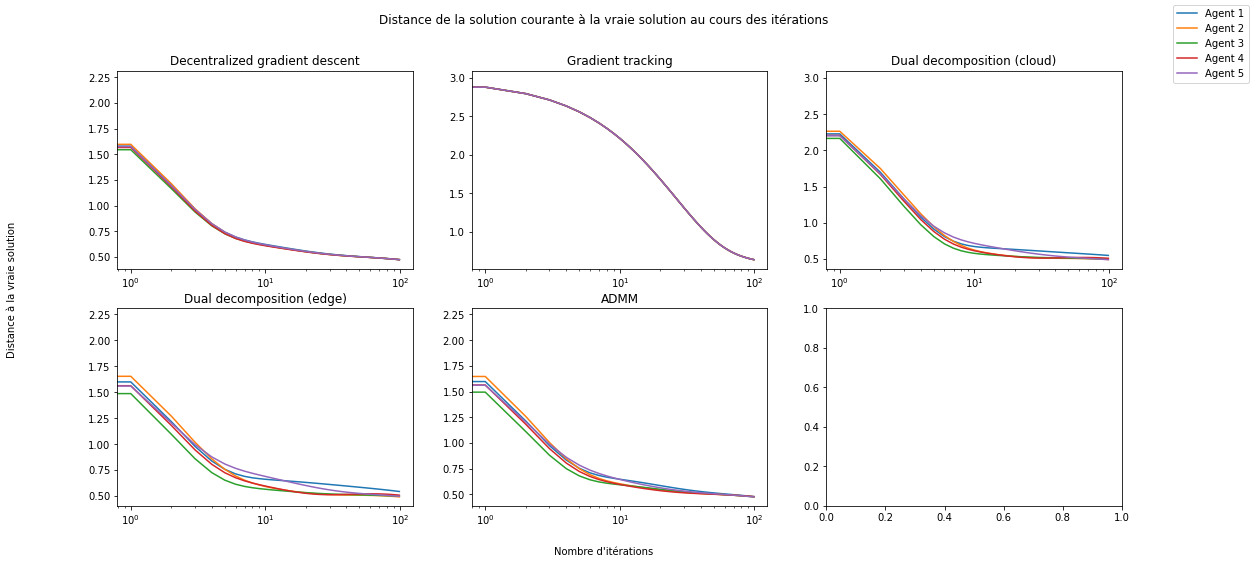

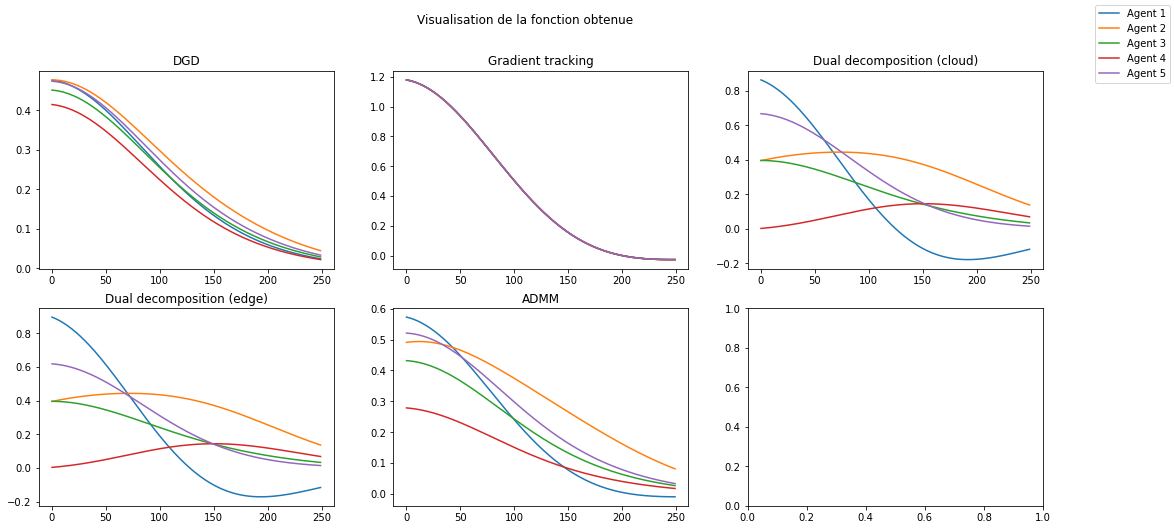

In [46]:
train_all_models(A1,False,0,1000)

**Fully connected** package loss probability = 0.3

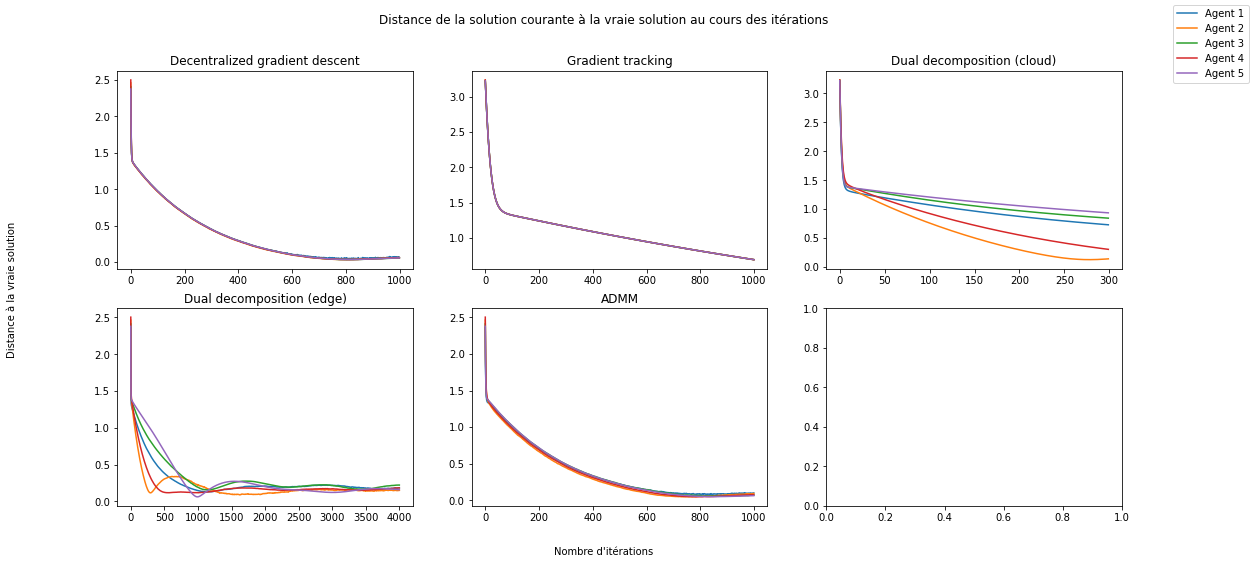

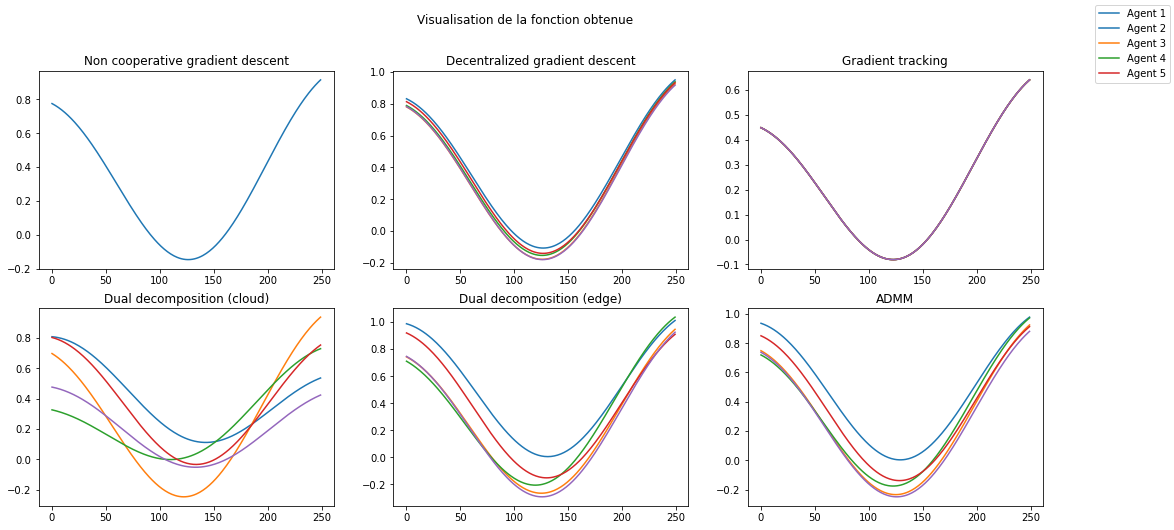

In [135]:
train_all_models(A1,True,0.3,1000)

**Fully connected** package loss probability = 0.6

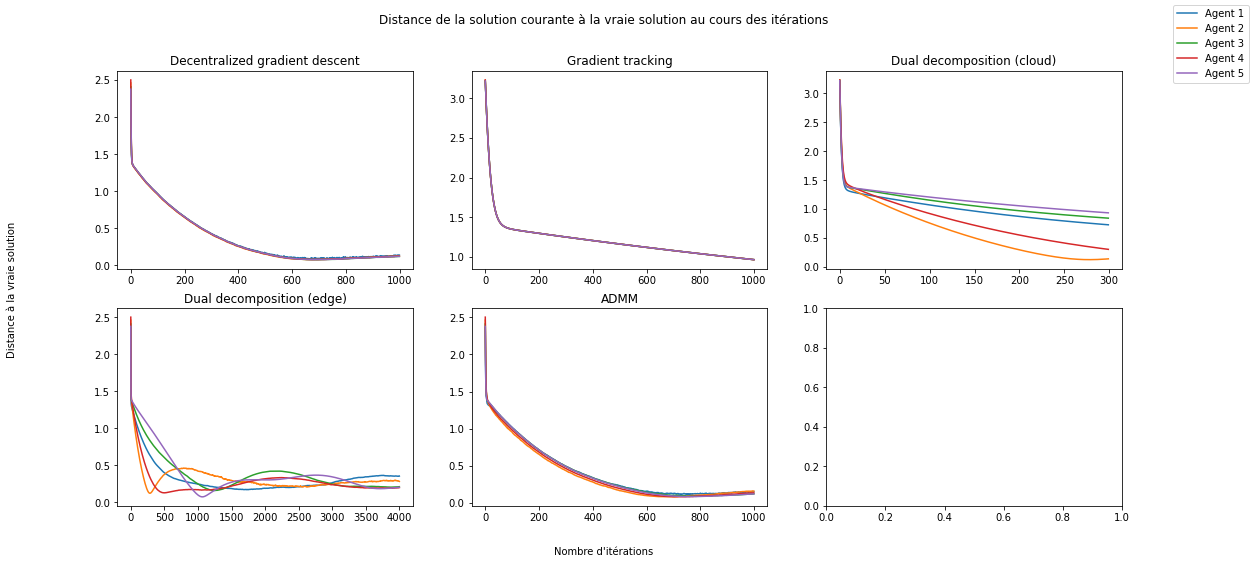

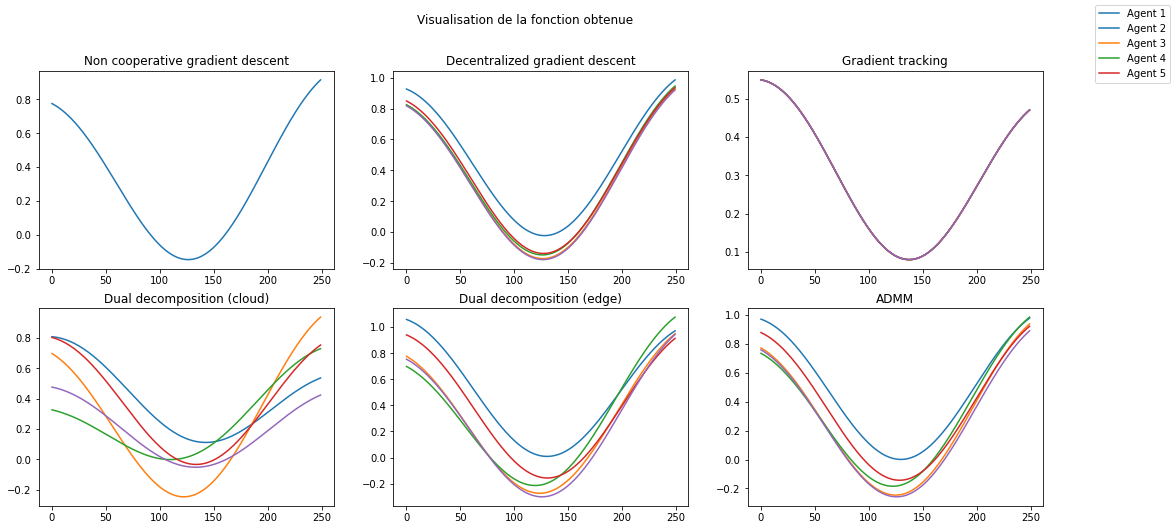

In [136]:
train_all_models(A1,True,0.6,1000)

**Small world**

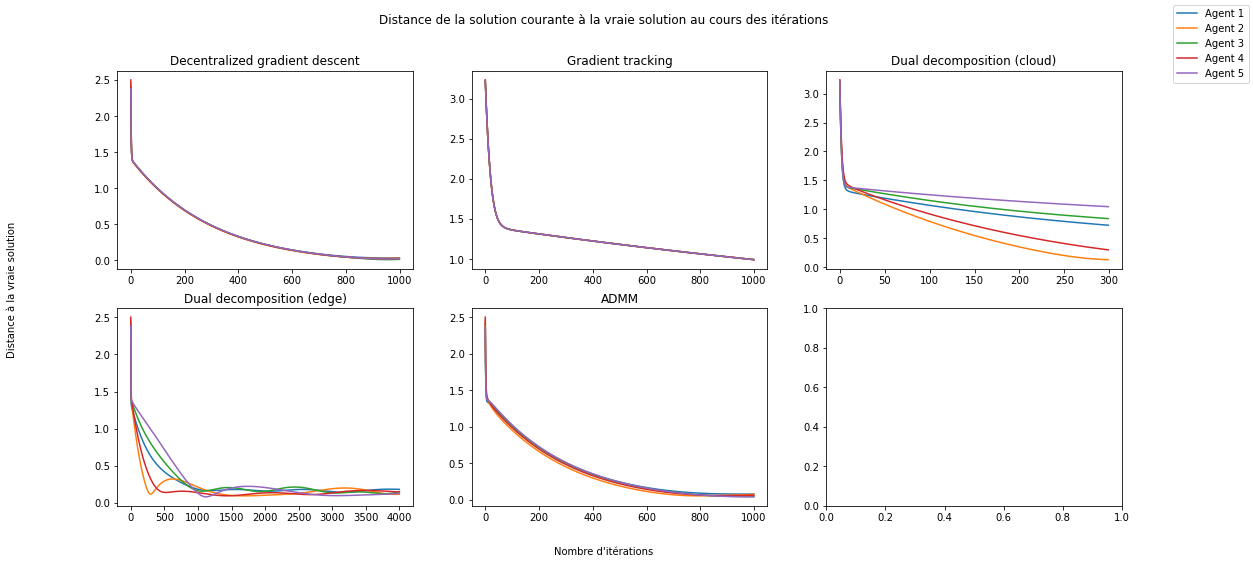

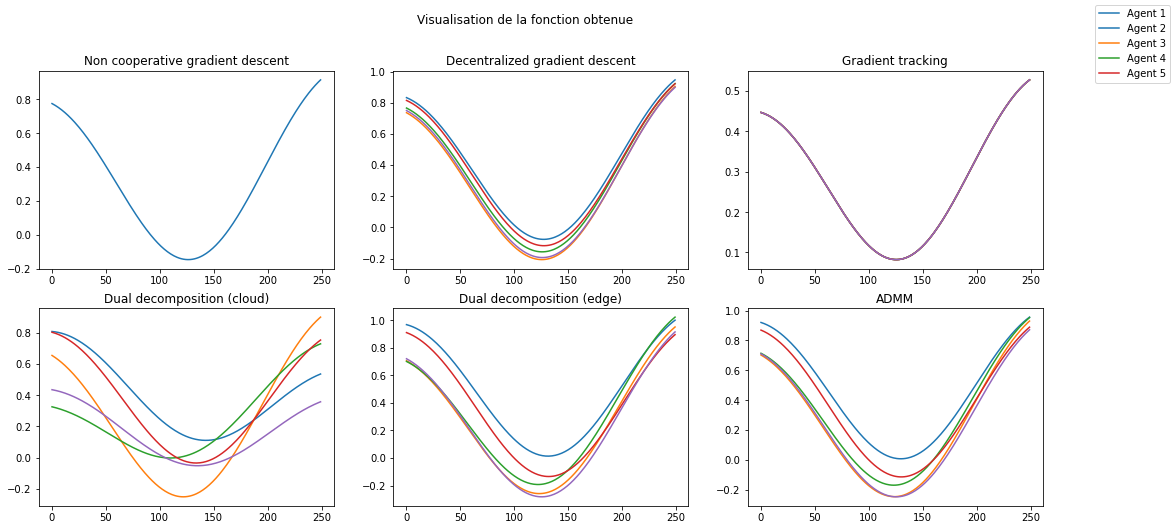

In [137]:
train_all_models(A2,False,0,1000)

**Cycle**

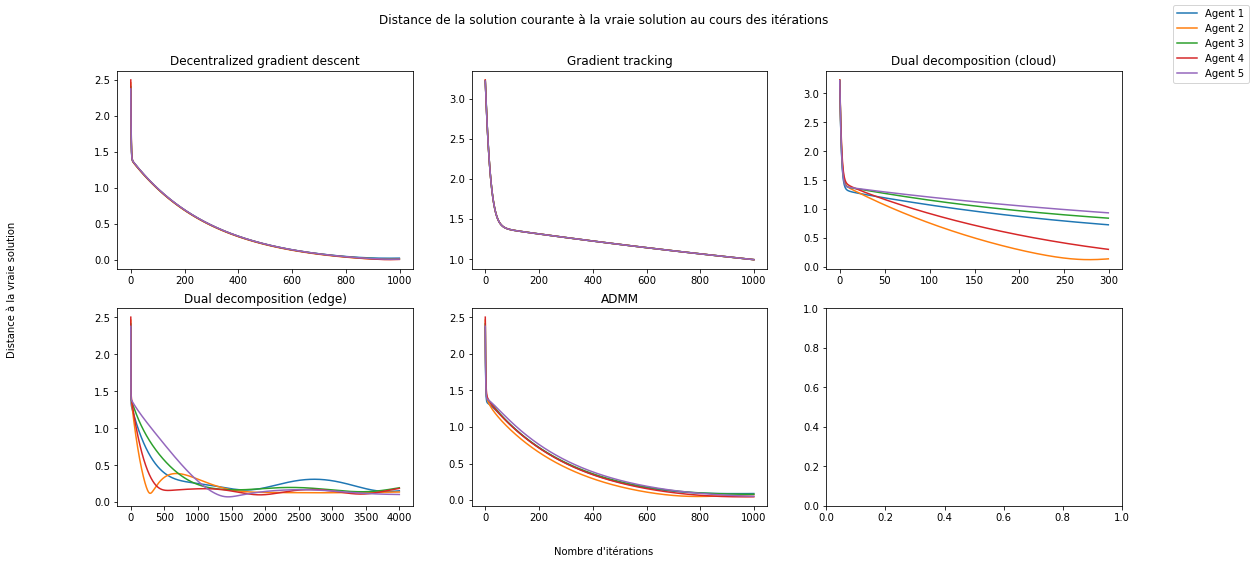

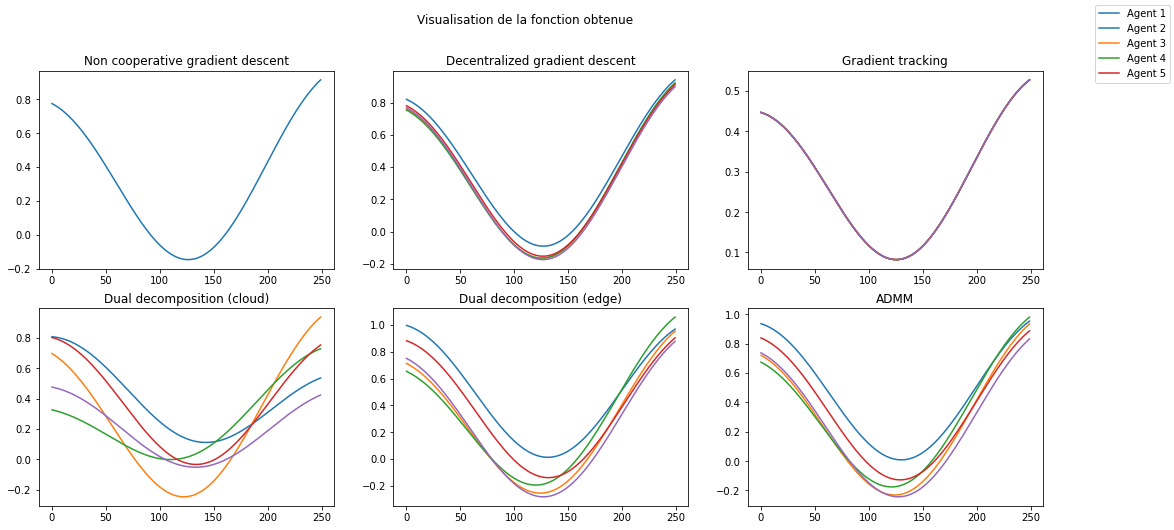

In [138]:
train_all_models(A3,False,0,1000)

**Line**

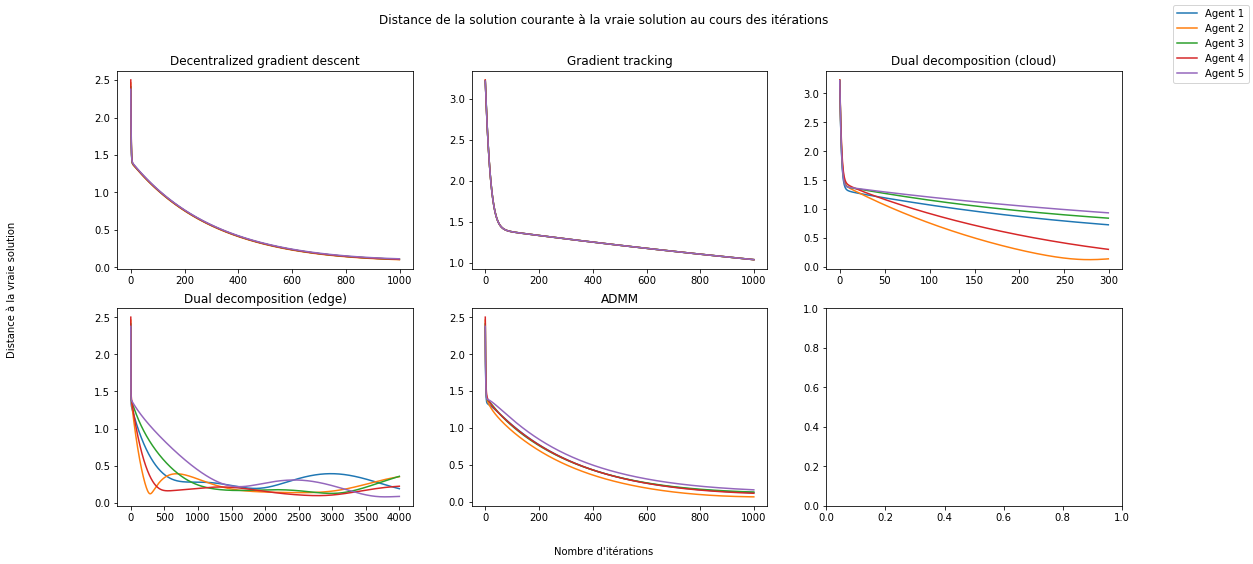

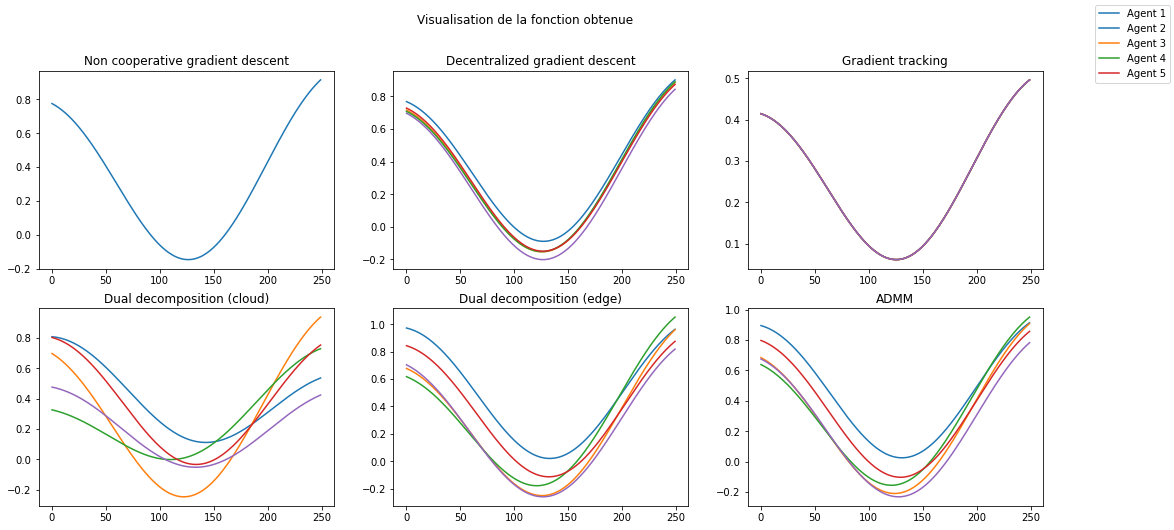

In [139]:
train_all_models(A4,False,0,1000)

**Non connex**

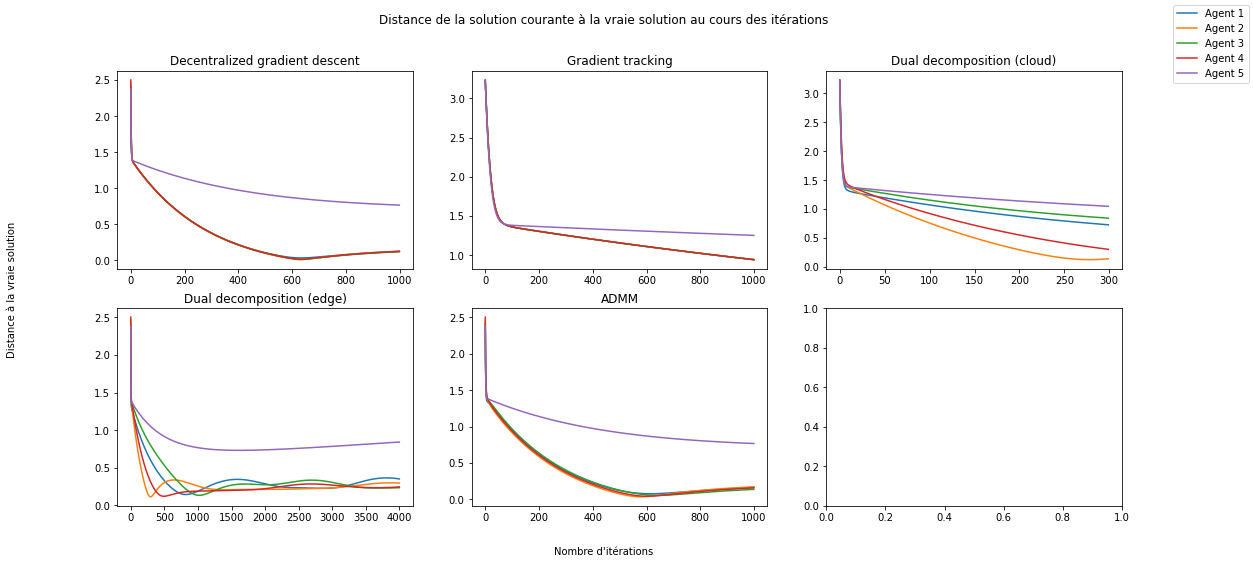

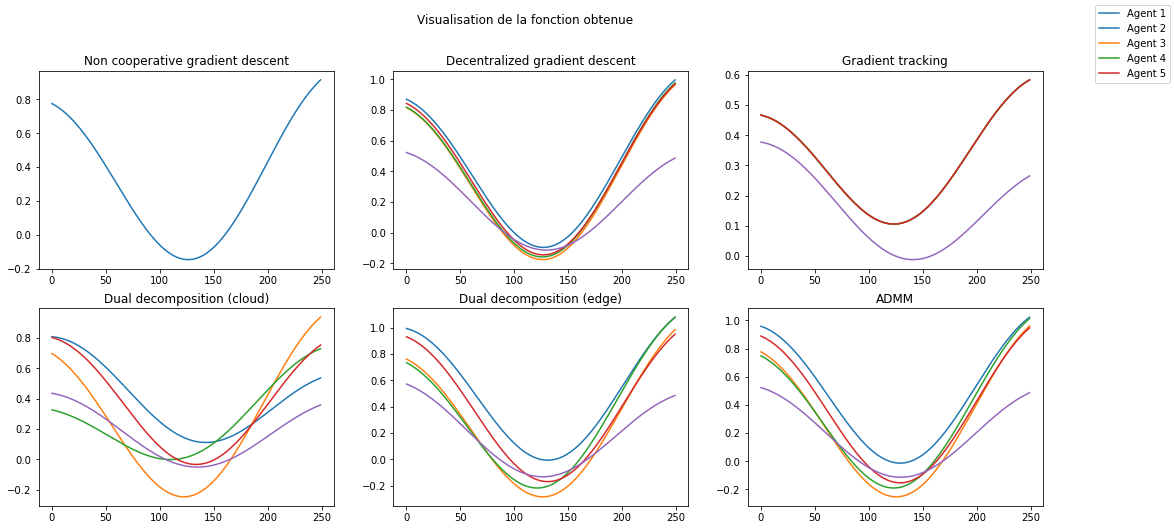

In [140]:
train_all_models(A5,False,0,1000)

**Directed communication** 

In [33]:
directed_1 = np.array([[1,0,1,0,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])
directed_2 = np.array([[1,0,1,0,1],[1,1,1,1,1],[0,1,1,1,1],[1,0,0,1,1],[1,0,0,0,1]])
directed_3 = np.array([[1,0,0,0,1],[0,1,0,1,1],[0,0,1,1,1],[0,0,0,1,1],[1,0,0,0,1]])
directed_4 = np.array([[1,1,0,0,0],[0,1,1,0,0],[0,0,1,1,0],[0,0,0,1,1],[1,0,0,0,1]])

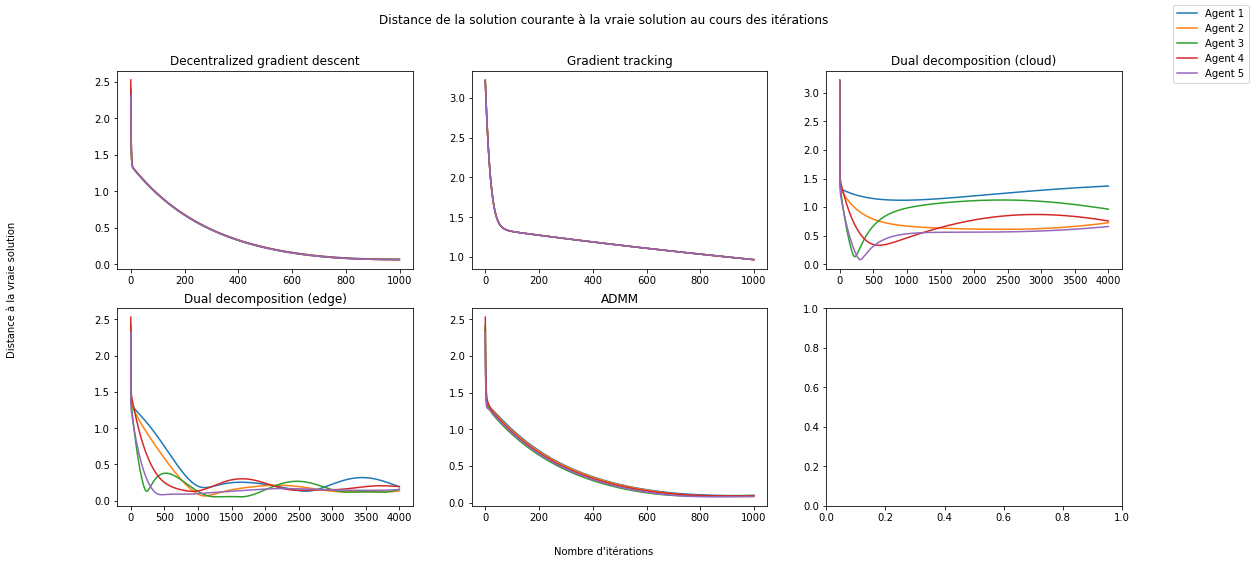

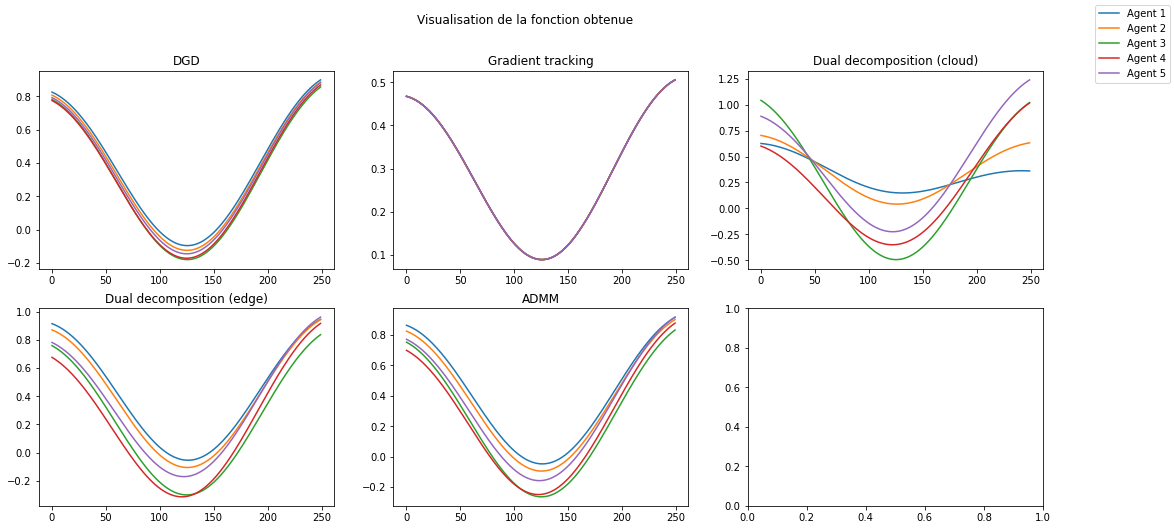

In [26]:
train_all_models(directed_1,False,0,1000)

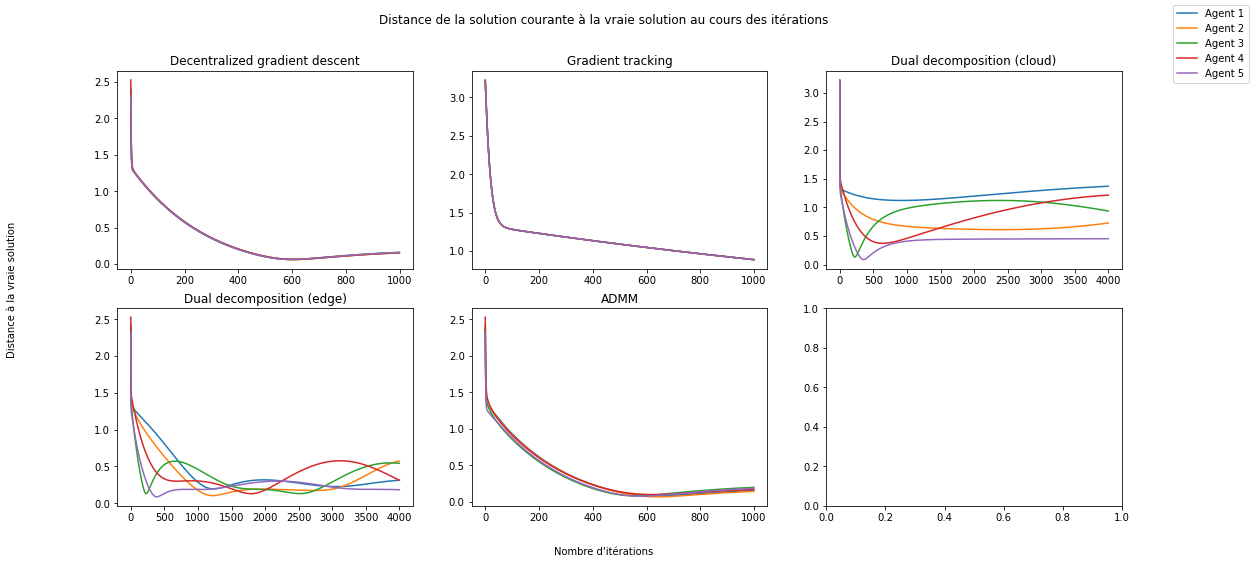

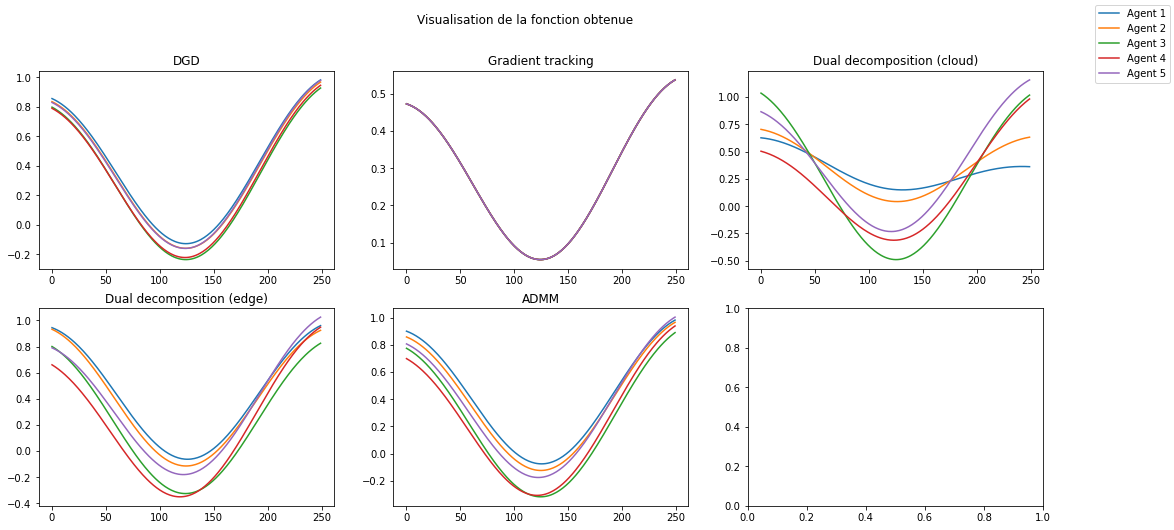

In [29]:
train_all_models(directed_2,False,0,1000)

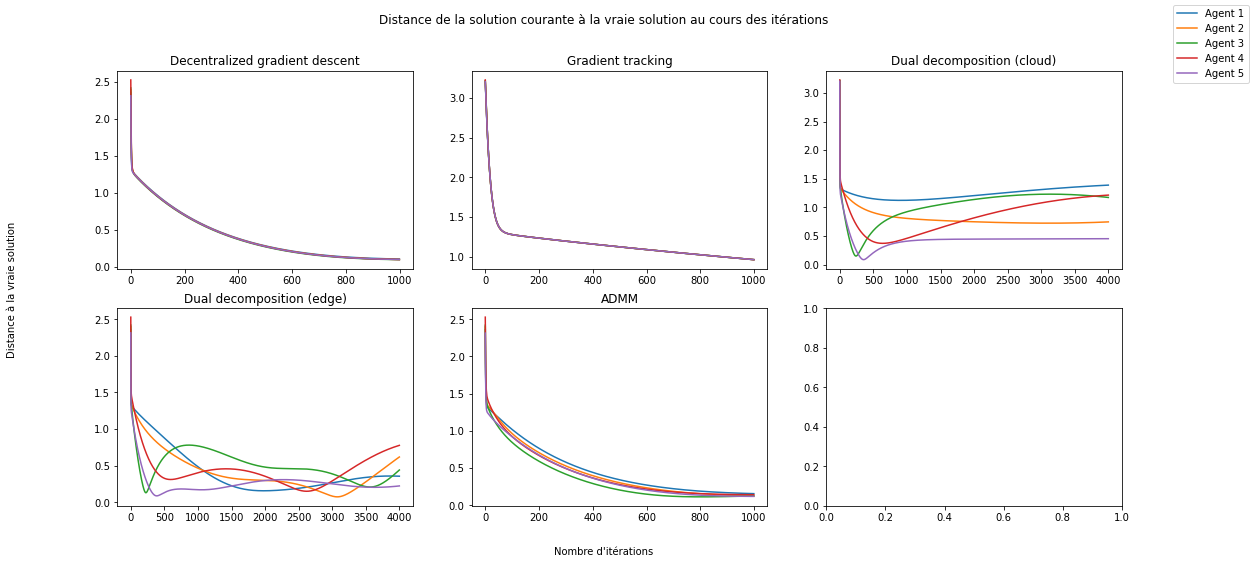

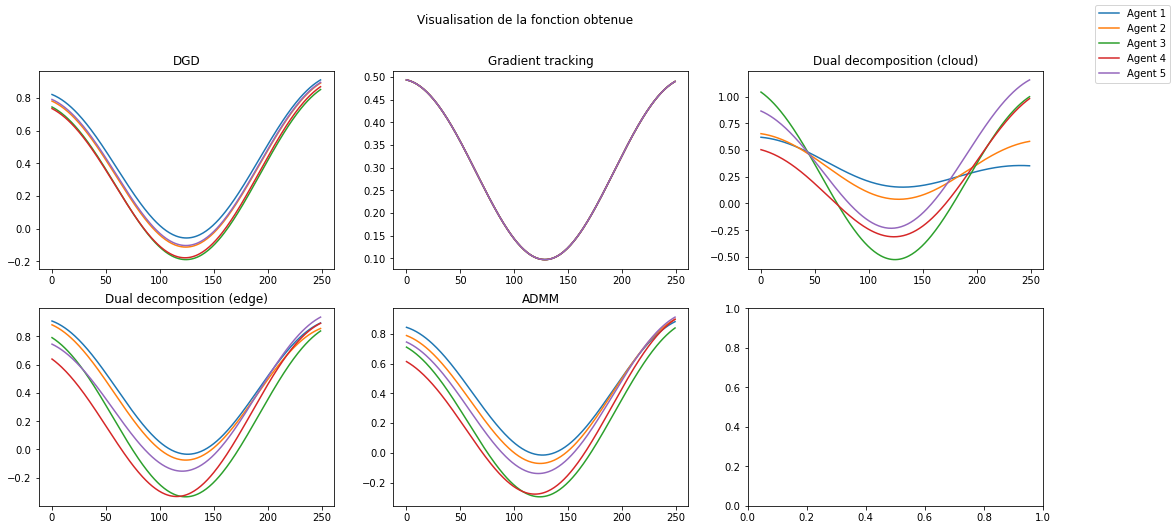

In [32]:
train_all_models(directed_3,False,0,1000)


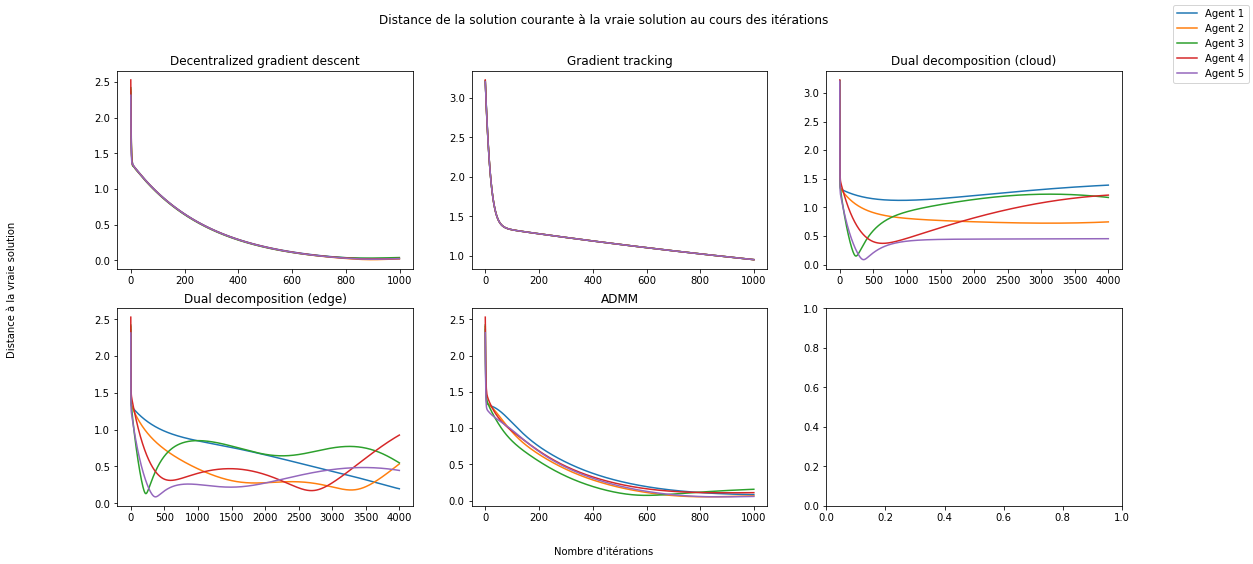

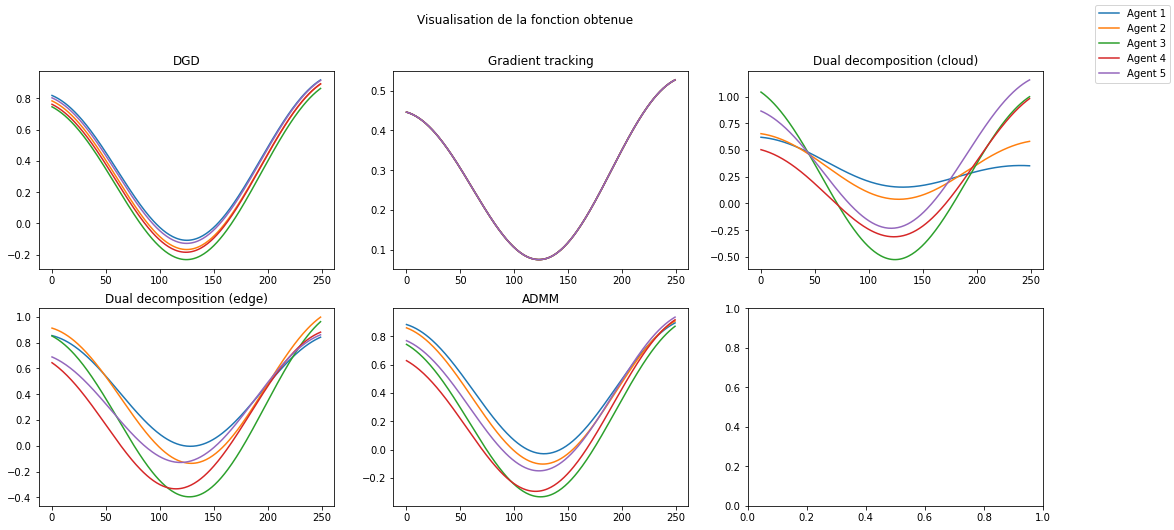

In [35]:
train_all_models(directed_4,False,0,1000)

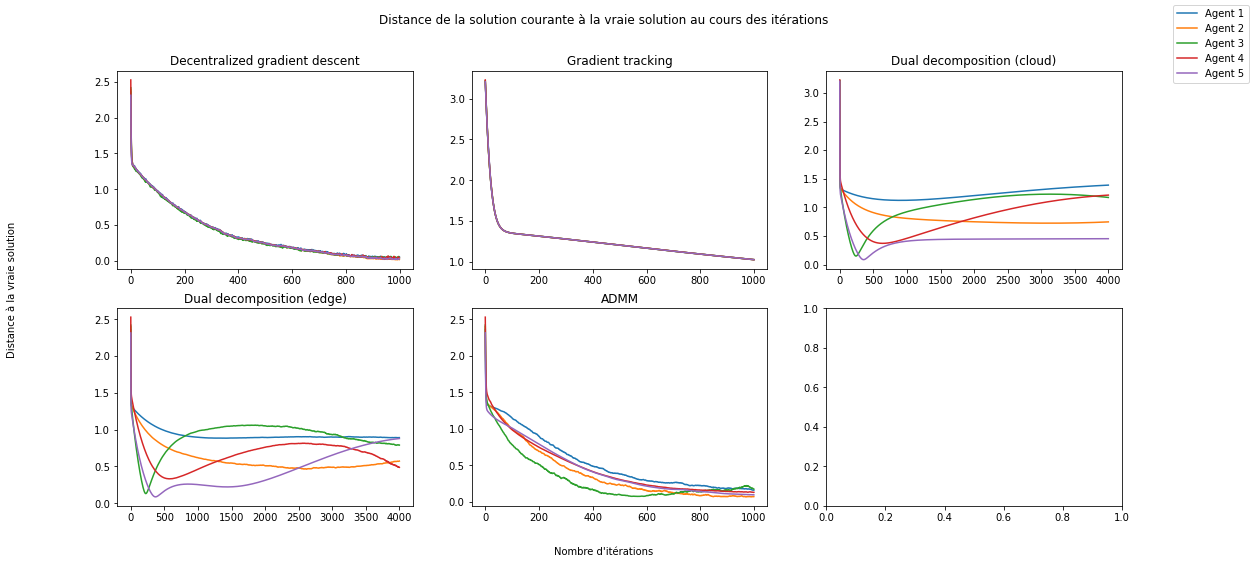

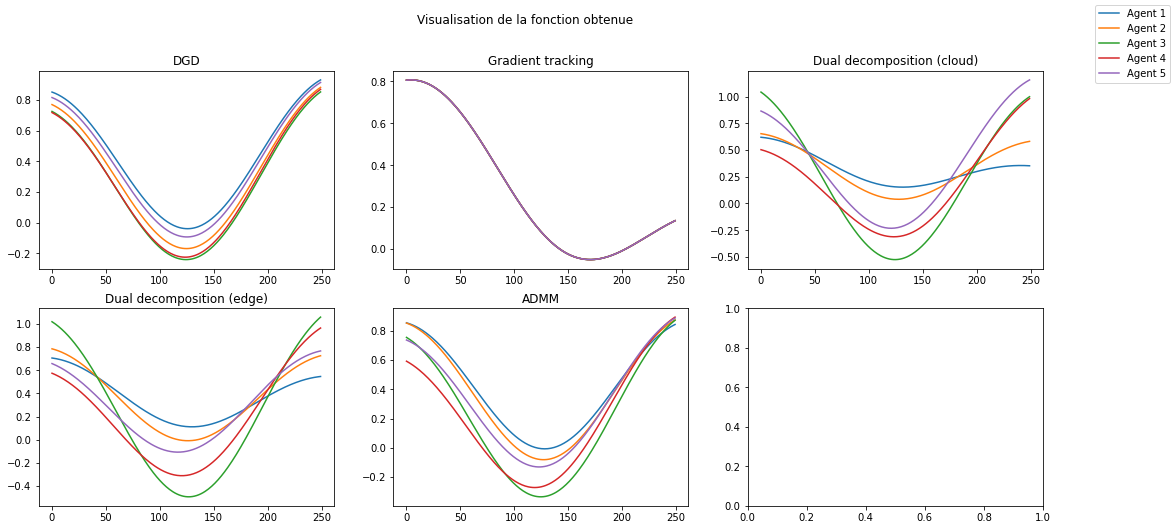

In [36]:
train_all_models(directed_4,True,0.5,1000)

# Partie II

 load data

In [11]:
with open("second_database.pkl", "rb") as f:
    X2, Y2 = pickle.load(f)

X2_array = np.array(X2)
Y2_array = np.array(Y2)

X2_flat = X2_array.flatten()
Y2_flat = Y2_array.flatten()

centers_kernel = np.array([X2_flat[10*i] for i in range(10)])
kernel_center_of_agent = np.array([[0,1],[2,3],[4,5],[6,7],[8,9]])
data_point_of_agent = np.array([np.arange(20*i,20*i+20) for i in range(5)])

 create instance

In [48]:
instance_pb_FedAvg = instance(X2_flat,centers_kernel,Y2_flat,kernel_center_of_agent,data_point_of_agent,A1,0.5)
solver_non_cooperative = gradient_descent(instance_pb_FedAvg,0.0001,2000,np.ones(10))
true_solution = solver_non_cooperative.solve(verbose=False)
instance_pb_FedAvg.true_solution =  true_solution
print(solver_non_cooperative.curent_solution)

[ 0.61259249  0.05778075  0.04098423 -0.00922053 -0.04594994 -0.01851024
  0.158987    0.00365649 -0.01068371 -0.01475932]


compute decentralized solution

In [49]:
solver_Fed = solver_FedAvg(instance_pb_FedAvg, 0.0001, 1000, np.ones(10),5,10,10)
solver_Fed.solve(verbose = False)
# print(solver_Fed.curent_server_solution)


plot convergence

In [52]:
def plot_convergence_fed_Avg(number_of_iterations,number_of_batches,number_of_epoch):
    instance_pb_FedAvg = instance(X2_flat,centers_kernel,Y2_flat,kernel_center_of_agent,data_point_of_agent,A1,0.5)
    solver_non_cooperative = gradient_descent(instance_pb_FedAvg,0.0001,2000,np.ones(10))
    true_solution = solver_non_cooperative.solve(verbose=False)
    instance_pb_FedAvg.true_solution =  true_solution

    solver_Fed = solver_FedAvg(instance_pb_FedAvg, 0.0001, number_of_iterations, np.ones(10),5,number_of_epoch,number_of_batches)
    solver_Fed.solve(verbose = False)

    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axs[0].semilogx(solver_Fed.distance_to_optimum)
    axs[0].semilogx(solver_Fed.distance_to_optimum_agent)
    axs[0].set_title("Distance à l'optimum au cours des itérations")
    axs[1].semilogx(solver_Fed.server_objective)
    axs[1].semilogx(solver_Fed.client_objective)
    axs[1].set_title("Objectif au cours des itérations")

    fig.suptitle("Tracé de la convergence de l'algorithme FedAvg")
    fig.legend(["Serveur","Client 1","Client 2","Client 3","Client 4","Client 5"])

    


10 epochs, 10 batches

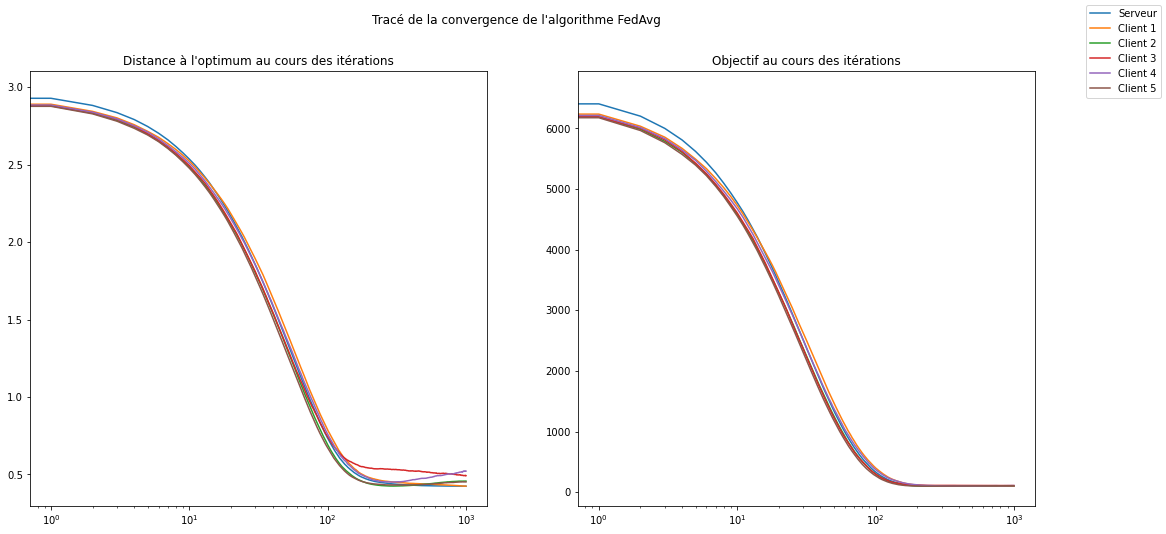

In [55]:
plot_convergence_fed_Avg(1000,10,10)

20 epochs 10 batches

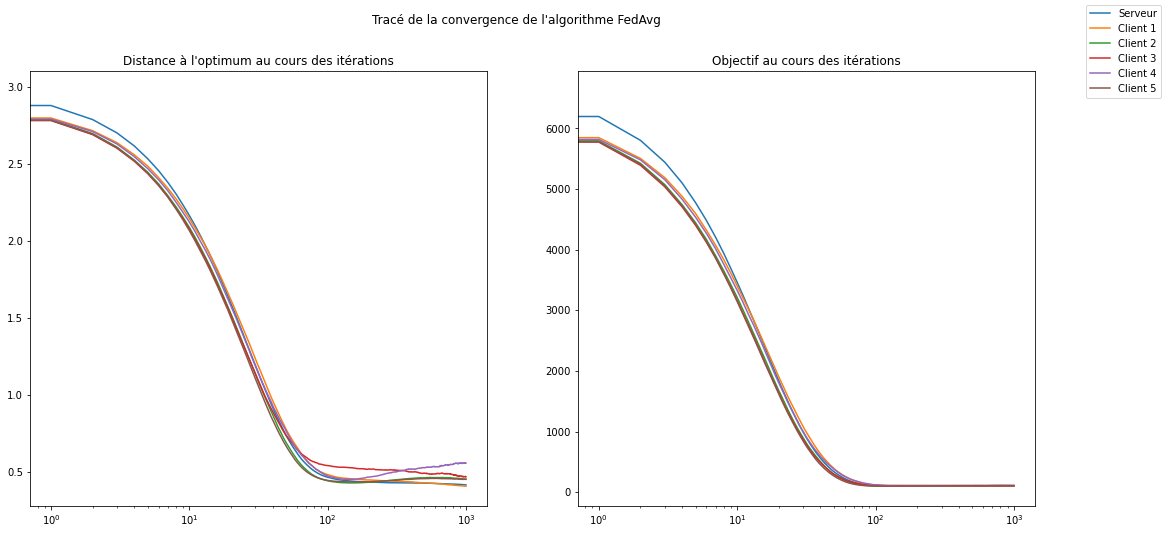

In [56]:
plot_convergence_fed_Avg(1000,10,20)

10 epochs 5 batches

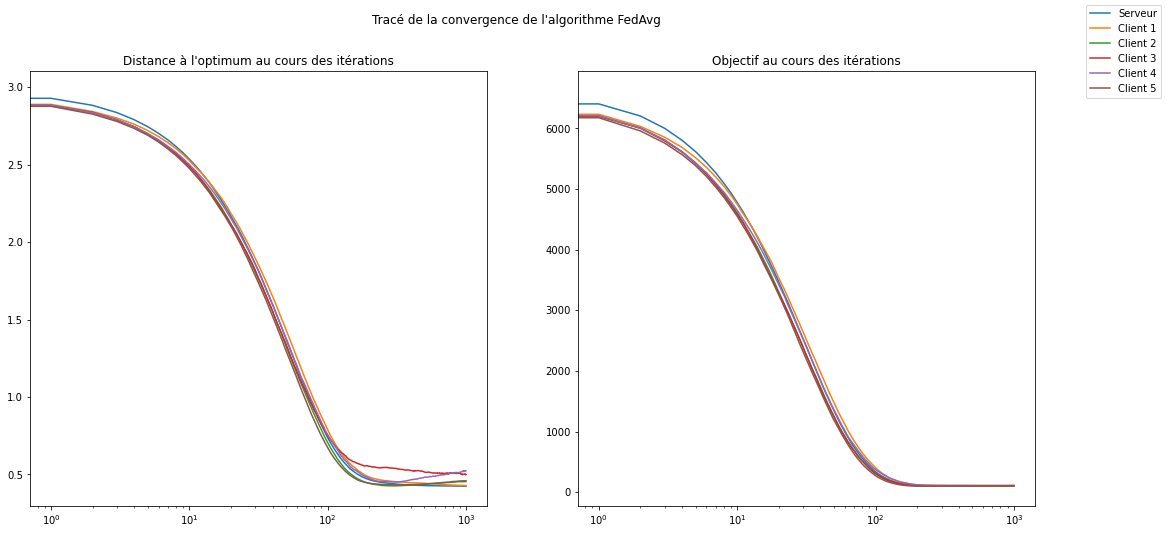

In [57]:
plot_convergence_fed_Avg(1000,5,10)

10 epochs 1 batch

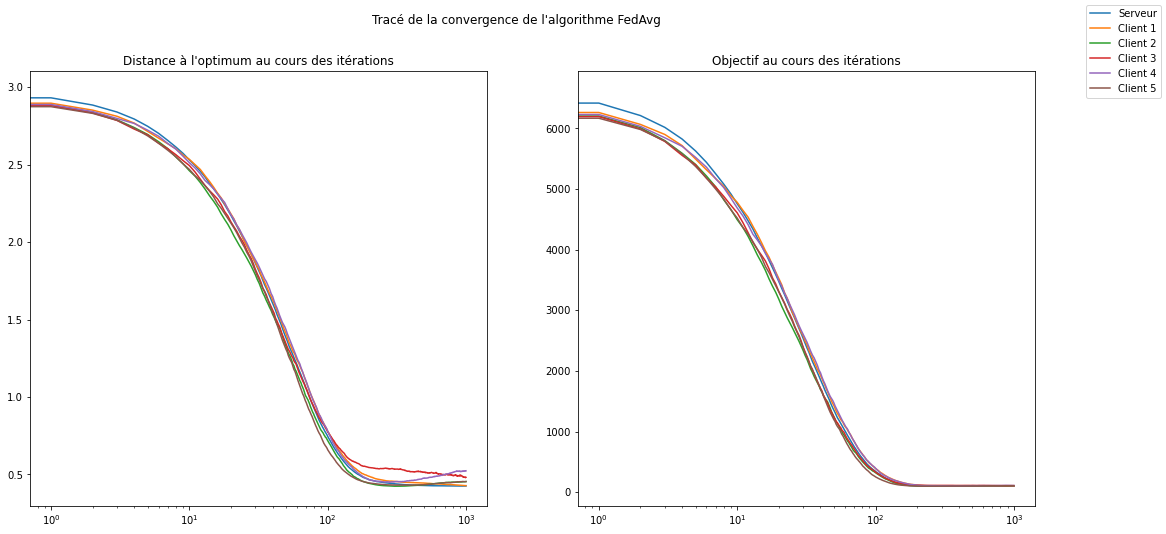

In [58]:
plot_convergence_fed_Avg(1000,1,10)

1 epoch 1 batch

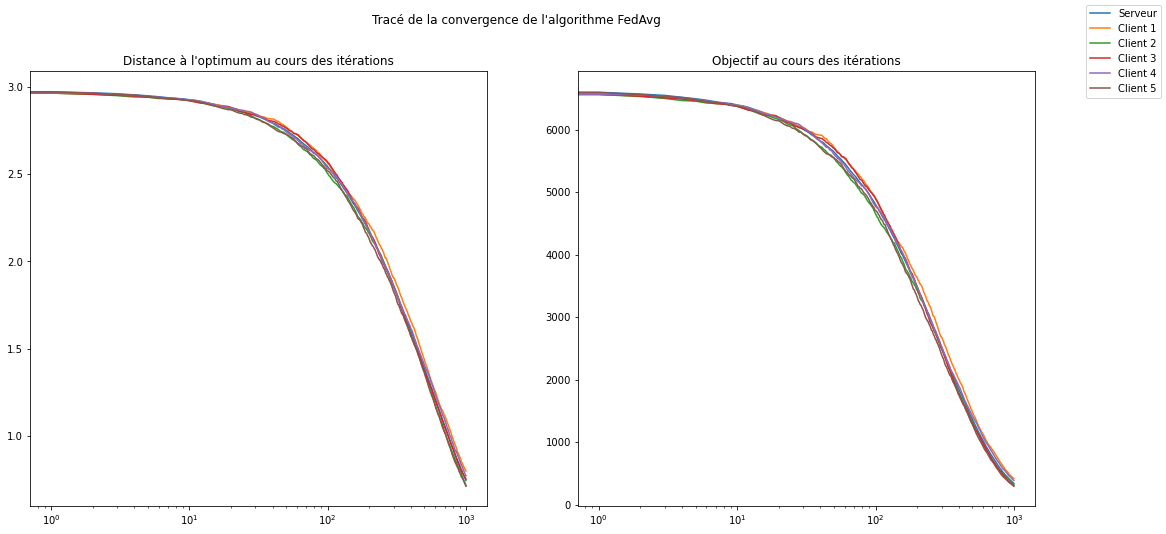

In [59]:
plot_convergence_fed_Avg(1000,1,1)
